In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [2]:
import flgo.algorithm.fedavg as fedavg
import flgo
flgo.gen_benchmark_from_file('traffic_forecasting', './config_traffic.py', '.', 'series', 'forecasting')
# 生成后需要自行先下载数据到traffic_forecasting中
task = 'test_tra'
flgo.gen_task({'benchmark':{'name':'traffic_forecasting'}, 'partitioner':{'name':'DeconcatPartitioner'}}, task)
flgo.init(task, fedavg, {'gpu':0, 'proportion':0.02, 'num_epochs':1, 'learning_rate':0.001}).run()

In [2]:
price=pd.read_csv('ST-EVCDP/datasets/price.csv')
volume=pd.read_csv('ST-EVCDP/datasets/volume.csv')
occ=pd.read_csv('ST-EVCDP/datasets/occupancy.csv')
dur=pd.read_csv('ST-EVCDP/datasets/duration.csv')
info=pd.read_csv('ST-EVCDP/datasets/information.csv')
time=pd.read_csv('ST-EVCDP/datasets/time.csv')

In [6]:
#转化为日期格式
timestamps=[]
for i in range(len(time)):
    date=str(time['year'][i])+'-'+str(time['month'][i])+'-'+str(time['day'][i])+' '+str(time['hour'][i])+':'+str(time['minute'][i])+':'+str(time['second'][i])
    timestamps.append(pd.to_datetime(date))
occ.index=timestamps

In [8]:
occ['102'].to_csv('102.csv')
occ['1162'].to_csv('1162.csv')

In [30]:
from sklearn.model_selection import train_test_split
station_value = occ['102']
df = pd.DataFrame({'Datetime':station_value.index, 'Occupancy':occ['102'].values})
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n['Occupancy'].shift(n)  #注意这里是以series的形式存储的，不读取列名
    df_n = df_n.iloc[n_lags:]
    return df_n
df_generated = generate_time_lags(df, 5)
df_generated.set_index('Datetime',inplace=True)

In [33]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
df_features = (df_generated
               .assign(day = df_generated.index.day)
               .assign(month = df_generated.index.month)
               .assign(day_of_week = df_generated.index.dayofweek)
               .assign(week_of_year = pd.Index(df_generated.index.isocalendar().week))
               )
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, y_train = shuffle(X_train, y_train)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_val_test_split(df_features,'Occupancy', 0.2)
def get_scaler(scaler):
        scalers = {
            "minmax": MinMaxScaler,
            "standard": StandardScaler,
            "maxabs": MaxAbsScaler,
            "robust": RobustScaler,
        }
        return scalers.get(scaler.lower())()
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_test_arr = scaler.transform(y_test)

In [35]:
y_train_arr

array([[0.52941176],
       [0.70588235],
       [0.70588235],
       ...,
       [0.76470588],
       [0.47058824],
       [0.58823529]])

In [8]:
occ=occ.set_index('timestamp')
occ['102']

timestamp
1       12
2       12
3       12
4       12
5       12
        ..
8636    18
8637    18
8638    18
8639    18
8640    16
Name: 102, Length: 8640, dtype: int64

In [11]:
occ

,102,105,107,108,109,110,111,115,123,124,...,1160,1162,1163,1164,1166,1167,1168,1170,1172,1173
timestamp,,,,,,,,,,,,,,,,,,,,,
1,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,162,10,1,8,15
2,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,162,10,1,8,15
3,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,164,10,1,8,15
4,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,166,10,1,8,15
5,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,168,10,1,8,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8636,18,14,17,17,10,9,17,3,5,8,...,0,10,3,51,28,194,11,0,10,16
8637,18,16,17,17,10,9,17,3,4,8,...,0,11,3,51,28,195,11,0,10,16
8638,18,16,17,17,10,9,17,3,4,8,...,0,11,3,51,28,195,11,0,10,16


In [100]:
occ

,102,105,107,108,109,110,111,115,123,124,...,1160,1162,1163,1164,1166,1167,1168,1170,1172,1173
timestamp,,,,,,,,,,,,,,,,,,,,,
1,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,162,10,1,8,15
2,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,162,10,1,8,15
3,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,164,10,1,8,15
4,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,166,10,1,8,15
5,12,16,24,15,6,8,24,1,2,10,...,0,12,1,38,26,168,10,1,8,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8636,18,14,17,17,10,9,17,3,5,8,...,0,10,3,51,28,194,11,0,10,16
8637,18,16,17,17,10,9,17,3,4,8,...,0,11,3,51,28,195,11,0,10,16
8638,18,16,17,17,10,9,17,3,4,8,...,0,11,3,51,28,195,11,0,10,16


In [6]:
price=price.set_index('timestamp')
dur=dur.set_index('timestamp')
occ=occ.set_index('timestamp')
volume=volume.set_index('timestamp')

In [43]:
time

,month,day,year,hour,minute,second
0,6,19,2022,0,0,0
1,6,19,2022,0,5,0
2,6,19,2022,0,10,0
3,6,19,2022,0,15,0
4,6,19,2022,0,20,0
...,...,...,...,...,...,...
8635,7,18,2022,23,35,0
8636,7,18,2022,23,40,0
8637,7,18,2022,23,45,0
8638,7,18,2022,23,50,0


[Timestamp('2022-06-19 00:00:00'),
 Timestamp('2022-06-19 00:05:00'),
 Timestamp('2022-06-19 00:10:00'),
 Timestamp('2022-06-19 00:15:00'),
 Timestamp('2022-06-19 00:20:00'),
 Timestamp('2022-06-19 00:25:00'),
 Timestamp('2022-06-19 00:30:00'),
 Timestamp('2022-06-19 00:35:00'),
 Timestamp('2022-06-19 00:40:00'),
 Timestamp('2022-06-19 00:45:00'),
 Timestamp('2022-06-19 00:50:00'),
 Timestamp('2022-06-19 00:55:00'),
 Timestamp('2022-06-19 01:00:00'),
 Timestamp('2022-06-19 01:05:00'),
 Timestamp('2022-06-19 01:10:00'),
 Timestamp('2022-06-19 01:15:00'),
 Timestamp('2022-06-19 01:20:00'),
 Timestamp('2022-06-19 01:25:00'),
 Timestamp('2022-06-19 01:30:00'),
 Timestamp('2022-06-19 01:35:00'),
 Timestamp('2022-06-19 01:40:00'),
 Timestamp('2022-06-19 01:45:00'),
 Timestamp('2022-06-19 01:50:00'),
 Timestamp('2022-06-19 01:55:00'),
 Timestamp('2022-06-19 02:00:00'),
 Timestamp('2022-06-19 02:05:00'),
 Timestamp('2022-06-19 02:10:00'),
 Timestamp('2022-06-19 02:15:00'),
 Timestamp('2022-06-

In [10]:
#全量数据分析，探究dur、price、occ和volume之间的关系
DUR, PRI, OCC, VOL=dur.T.mean(), price.T.mean(), occ.T.mean(), volume.T.mean()
delta=VOL/DUR

In [11]:
# Create traces
index = timestamps
#layout=go.layout(yaxis2=dict(anchor='x',overlaying='y',side='right'))
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{'secondary_y':True}]])
fig.add_trace(go.Scatter(x=index, y=DUR,mode='lines',name='Duration'),secondary_y=True)
fig.add_trace(go.Scatter(x=index, y=PRI,mode='lines',name='Price'),secondary_y=True)
fig.add_trace(go.Scatter(x=index, y=delta,mode='lines',name='效率'))
fig.add_trace(go.Scatter(x=index, y=OCC,mode='lines',name='Occupancy'))
fig.add_trace(go.Scatter(x=index, y=VOL,mode='lines',name='Volume'))
fig.show()

In [49]:
table=price
isDy=[str(x) for x in info[info['dynamic_pricing']==1]['grid'].to_list()]
notDy=[str(x) for x in info[info['dynamic_pricing']==0]['grid'].to_list()]
dyOcc, fiOcc=price[isDy].T.mean(), price[notDy].T.mean()
random_x = timestamps
random_y0 = price['206'].T#dyOcc
random_y1 = price['223'].T#fiOcc
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='动态定价'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='固定定价'))
fig.show()
isCBD=[str(x) for x in info[info['CBD']==1]['grid'].to_list()]
notCBD=[str(x) for x in info[info['CBD']==0]['grid'].to_list()]
isCBDOcc, notCBDOcc=table[isCBD].T.mean(), table[notCBD].T.mean()
random_x = occ.index
random_y0 = isCBDOcc
random_y1 = notCBDOcc

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='CBD区域充电站'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='非CBD区域充电站'))
fig.show()

In [ ]:
#绘制地点分布图
import folium
from folium import plugins
lat, lon = info.la[0],info.lon[0]
shenzhen_map=folium.Map(location=[lat, lon],tiles="Cartodb Positron",zoom_start=12)
charging_station = plugins.MarkerCluster().add_to(shenzhen_map)
for lat, lon, label in zip(info.la, info.lon, info.grid):
    folium.Marker(
        location=[lat,lon],
        icon=None,
        popup=label
    ).add_to(charging_station)
shenzhen_map.add_child(charging_station)
shenzhen_map.save('map.html')

In [67]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

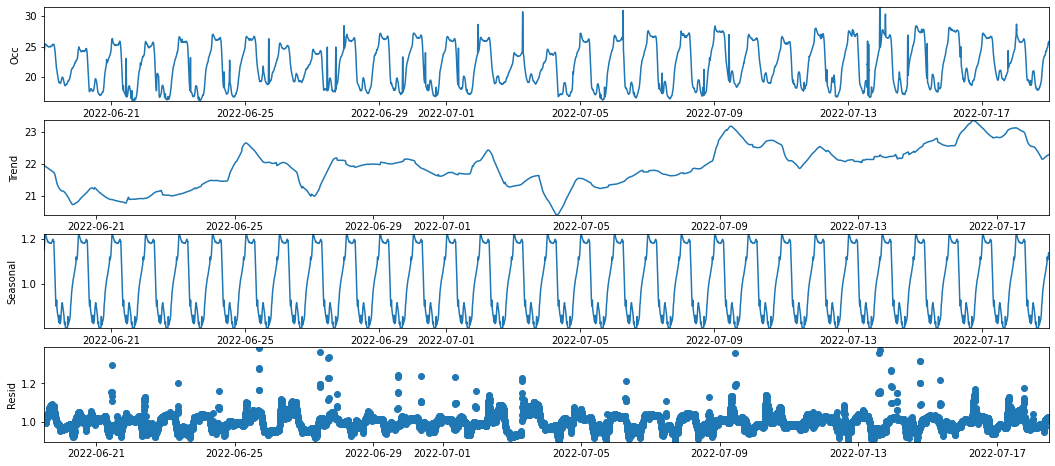

In [40]:
import matplotlib.pyplot as plt
OCC.index=timestamps
result=seasonal_decompose(OCC,model='multiplicative',period=288)
plt.figure(figsize=(18,8))

plt.subplot(4,1,1)
plt.plot(result.observed, label="Copper Future")
plt.ylabel("Occ")
#plt.xticks(timestamps[::576], rotation=0) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
#plt.xticks(timestamps[::288], rotation=0)
plt.margins(0)

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
#plt.xticks(timestamps[::288], rotation=0)
plt.margins(0)

plt.subplot(4,1,4)
plt.scatter(OCC.index,result.resid)
plt.ylabel("Resid")
#plt.xticks(timestamps[::288], rotation=0)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

In [36]:
#执行DF检测
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================") 
    

In [43]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(OCC)

Results of Dickey-Fuller Test
Test Statistic                -9.541098e+00
p-value                        2.725336e-16
#Lags Used                     3.700000e+01
Number of Observations Used    8.602000e+03
Criterical Value (1%)         -3.431110e+00
Criterical Value (5%)         -2.861876e+00
Criterical Value (10%)        -2.566949e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


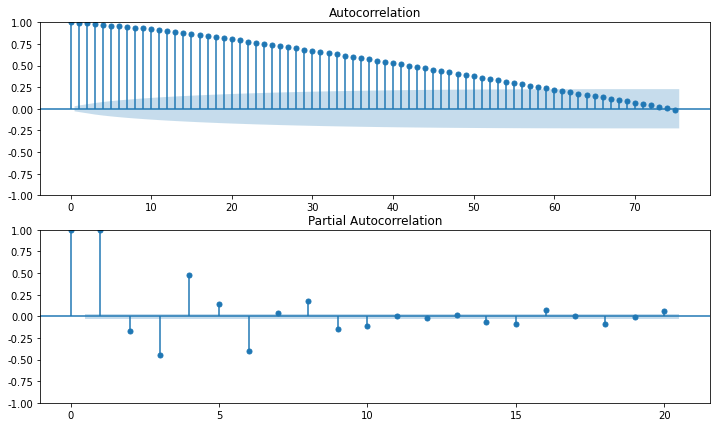

In [60]:
#correlogram
half=int(len(OCC)/2)
arima_data=OCC[:half]
f = plt.figure(figsize=(12,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data,lags=75,ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(arima_data,lags=20,ax=ax2)
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

ARIMA(0,0,0)：AIC=22494.16734056654
ARIMA(1,0,0)：AIC=2417.083526231878
ARIMA(2,0,0)：AIC=2278.661824587245
ARIMA(3,0,0)：AIC=1306.259881849484
ARIMA(4,0,0)：AIC=84.61872783837856
ARIMA(5,0,0)：AIC=-1.2036171907245148
ARIMA(6,0,0)：AIC=-981.4126238751653
ARIMA(7,0,0)：AIC=-994.3727355199087
ARIMA(8,0,0)：AIC=-1249.6713618078836
ARIMA(9,0,0)：AIC=-1459.8840350864511
ARIMA(10,0,0)：AIC=-1550.4643157726753
ARIMA(11,0,0)：AIC=-1579.3447913051164
ARIMA(12,0,0)：AIC=-1580.245980906801
ARIMA(13,0,0)：AIC=-1583.5693133806922
ARIMA(14,0,0)：AIC=-1596.903492895866
ARIMA(15,0,0)：AIC=-1623.8054331271103
ARIMA(16,0,0)：AIC=-1660.8996174488568
ARIMA(17,0,0)：AIC=-1659.4649761365654
ARIMA(18,0,0)：AIC=-1753.0087732368656
ARIMA(19,0,0)：AIC=-1751.6922273637601
This best model is ARIMA(18,0,0) based on argmin AIC.


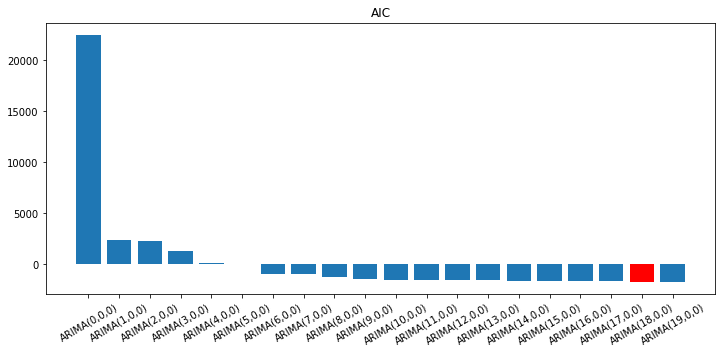

In [95]:
#p=10,q=0,d=0
def arima_AIC(data, p=11, d=0, q=0):
    best_AIC =["pdq",10000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        model = ARIMA(data, order=(i,0,0))
        fitted = model.fit()
        AIC.append(fitted.aic)
        name.append(f"ARIMA({i},{0},{0})")
        print(f"ARIMA({i},{0},{0})：AIC={fitted.aic}")
        if fitted.aic < best_AIC[1]:
            best_AIC[0] = f"ARIMA({i},{0},{0})"
            best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.savefig("Arima AIC")
    plt.show()
arima_AIC(arima_data, 20,0,0)

In [92]:
#预测后三天数据
import warnings
warnings.filterwarnings("ignore")
period=288
L=len(arima_data)
train = arima_data[:(L-period)]
test = arima_data[-period:]
model=ARIMA(train,dates=train.index,order=(11,0,0))
fitted = model.fit()
fc = fitted.forecast(period)
mse = mean_squared_error(test, fc)
print(f"ARIMA(11,0,0)：MSE={mse}")

ARIMA(11,0,0)：MSE=3.8263981478547953


In [89]:
arima_data.index

DatetimeIndex(['2022-06-19 00:00:00', '2022-06-19 00:05:00',
               '2022-06-19 00:10:00', '2022-06-19 00:15:00',
               '2022-06-19 00:20:00', '2022-06-19 00:25:00',
               '2022-06-19 00:30:00', '2022-06-19 00:35:00',
               '2022-06-19 00:40:00', '2022-06-19 00:45:00',
               ...
               '2022-07-03 23:10:00', '2022-07-03 23:15:00',
               '2022-07-03 23:20:00', '2022-07-03 23:25:00',
               '2022-07-03 23:30:00', '2022-07-03 23:35:00',
               '2022-07-03 23:40:00', '2022-07-03 23:45:00',
               '2022-07-03 23:50:00', '2022-07-03 23:55:00'],
              dtype='datetime64[ns]', length=4320, freq=None)

2022-07-03 00:00:00    22.437701
2022-07-03 00:05:00    22.513465
2022-07-03 00:10:00    22.468501
2022-07-03 00:15:00    22.496240
2022-07-03 00:20:00    22.468371
                         ...    
2022-07-03 23:35:00    21.647672
2022-07-03 23:40:00    21.647297
2022-07-03 23:45:00    21.646926
2022-07-03 23:50:00    21.646559
2022-07-03 23:55:00    21.646197
Freq: 5T, Name: predicted_mean, Length: 288, dtype: float64

ARIMA(8,0,0)：MSE=0.011427377786613749
ARIMA(9,0,0)：MSE=0.009934762805149041
ARIMA(10,0,0)：MSE=0.006512654410488248
ARIMA(11,0,0)：MSE=0.006816476683359511
ARIMA(12,0,0)：MSE=0.007040799013778568
ARIMA(13,0,0)：MSE=0.006882909839861072
ARIMA(14,0,0)：MSE=0.00673660346244534
ARIMA(15,0,0)：MSE=0.006825535626479796
ARIMA(16,0,0)：MSE=0.005891107135626446
ARIMA(17,0,0)：MSE=0.005738324620024632
ARIMA(18,0,0)：MSE=0.005332750267854435
ARIMA(19,0,0)：MSE=0.005385077234935527
This best model is ARIMA(18,0,0) based on argmin MSE.


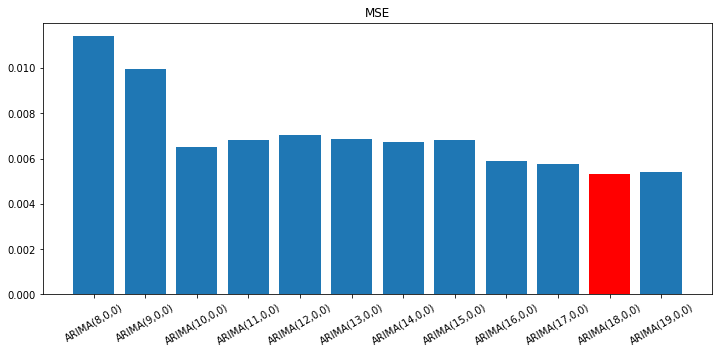

In [94]:
def arima_mse(data, p=4, d=3, q=4):
    period = 3 #預測三期
    best_pdq =["pdq",10000]
    L =len(data)
    train = data[:(L-period)]
    test = data[-period:]
    mse_r = []
    name = []
    for i in range(8,p):            
        model = ARIMA(train, order=(i,0,0))
        fitted = model.fit()
        fc = fitted.forecast(period, alpha=0.05)  
        mse = mean_squared_error(test,fc)
        mse_r.append(mse)
        name.append(f"ARIMA({i},{0},{0})")
        print(f"ARIMA({i},{0},{0})：MSE={mse}")
        if mse < best_pdq[1]:
            best_pdq[0] = f"ARIMA({i},{0},{0})"
            best_pdq[1] = mse
    print("==========================================================================")
    print(f"This best model is {best_pdq[0]} based on argmin MSE.")
    plt.figure(figsize=(12,5))
    plt.bar(name, mse_r)
    plt.bar(best_pdq[0], best_pdq[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("MSE")
    plt.savefig("Arima MSE")
    plt.show()
arima_mse(arima_data, 20,0,0)

In [96]:
model = ARIMA(train, order=(18,0,0))
fitted = model.fit()
fc = fitted.forecast(period, alpha=0.05)

In [98]:
fc.to_csv('result.csv')

In [ ]:
from datasets import Dataset
from flwr_datasets.partitioner import IidPartitioner

dataset = Dataset.from_pandas(occ.T)

partitioner = IidPartitioner(2)
partitioner.dataset = dataset
partition = partitioner.load_partition(partition_id=0)